#### This ipynb checks the difference between Peter's VG data and mine.
* image_ids
* object categories
* attribute categories

In [40]:
import json
import numpy as np
import os
import os.path as osp
import sys
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 10)
from pprint import pprint
import time
import collections
import seaborn as sns
import operator
from tqdm import tqdm

#### Check Genome Meta
made by 'tools/make_vg_meta.py'

In [41]:
meta = json.load(open('../datasets/genome/annotations/meta.json'))

In [42]:
attributes = meta['attributes']
att_to_cnt = meta['att_to_cnt']

In [43]:
cnts = np.array([att_to_cnt[att['name']] for att in attributes])
alpha = 2.
weights = np.exp(- alpha * cnts**0.5 / max(cnts**0.5))

In [44]:
# for i, att in enumerate(attributes):
#     print(att['id'], att, att_to_cnt[att['name']], weights[i])
total_weight = 0
for i, att in enumerate(attributes):
    total_weight += cnts[i] * weights[i]
print(total_weight/cnts.sum())

0.4506898739685568


#### Visualize Genome Annotations

In [30]:
instances = json.load(open('../datasets/genome/annotations/instances_val.json'))
print(instances.keys())

# make mappings
id_to_cat = {cat['id']: cat['name'] for cat in instances['categories']}
id_to_att = {att['id']: att['name'] for att in instances['attributes']}
images = instances['images']
Images = {img['id']: img for img in images}
iid_to_anns = collections.defaultdict(list)
for ann in instances['annotations']:
    iid_to_anns[ann['image_id']].append(ann)

dict_keys(['images', 'annotations', 'attributes', 'categories'])


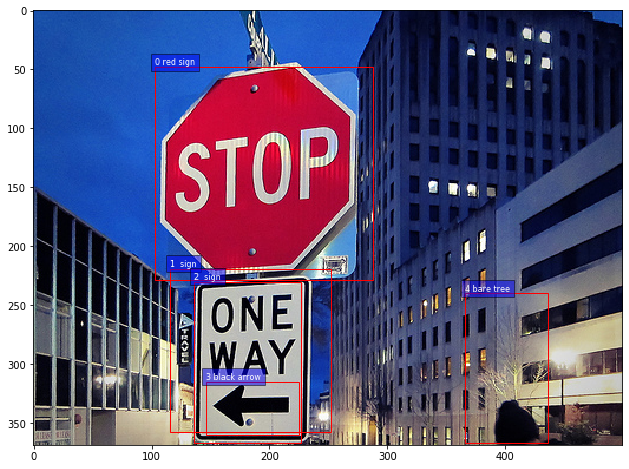

In [39]:
# show some image
ix = -125
img = images[ix]
# iid = 2324582
# img = Images[iid]
anns = iid_to_anns[img['id']]
im = plt.imread(osp.join('../datasets/vg', img['file_name']))
plt.rcParams['figure.figsize'] = (12, 8); plt.imshow(im)

for i, ann in enumerate(anns[:5]):
    bbox = ann['bbox']
    object_cls = id_to_cat[ann['category_id']]
    attribute_cls = ','.join([id_to_att[att_id] for att_id in ann['attribute_ids']])
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2],
                      bbox[3], fill=False,
                      edgecolor='red', linewidth=1)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '{} {:s} {:s}'.format(i,attribute_cls,object_cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=8, color='white')
plt.show()

#### check how many attributes and objects are there

In [26]:
def histogram(wd_to_cnt, topK):
    wd_cnt = sorted(wd_to_cnt.items(), key=operator.itemgetter(1))[::-1]
    wds = [wd for wd, _ in wd_cnt[:topK]]
    cnts = [cnt for _, cnt in wd_cnt[:topK]]
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.bar(wds, cnts, 0.6, color='b')
    ax.tick_params(axis='x', rotation=45)
    plt.show()

In [27]:
split = 'train'
instances = json.load(open(f'../datasets/genome/annotations/filtered_instances_{split}.json'))
# make mappings
id_to_cat = {cat['id']: cat['name'] for cat in instances['categories']}
id_to_att = {att['id']: att['name'] for att in instances['attributes']}
images = instances['images']
iid_to_anns = collections.defaultdict(list)
for ann in instances['annotations']: iid_to_anns[ann['image_id']].append(ann)

In [28]:
# number of objects, attributes
obj_to_cnt = collections.Counter()
att_to_cnt = collections.Counter()
num_imgs, num_objs, num_atts = 0, 0, 0
for img in images:
    num_imgs += 1
    anns = iid_to_anns[img['id']]
    num_objs += len(anns)
    for ann in anns:
        obj_to_cnt[id_to_cat[ann['category_id']]] += 1
        for att_id in ann['attribute_ids']:
            num_atts += 1
            att_to_cnt[id_to_att[att_id]] += 1
num_objs_per_img = num_objs / num_imgs
num_atts_per_img = num_atts / num_imgs
print(f'Each image has {num_objs_per_img:.2f} objects and {num_atts_per_img:.2f} attributes.')
print(f'For {split}, there are {num_objs} objects and {num_atts} attributes in {num_imgs} images.')
print(f'{len(obj_to_cnt)} objects and {len(att_to_cnt)} attributes to be detected.')

Each image has 30.62 objects and 15.93 attributes.
For train, there are 2920006 objects and 1518981 attributes in 95358 images.
1600 objects and 400 attributes to be detected.


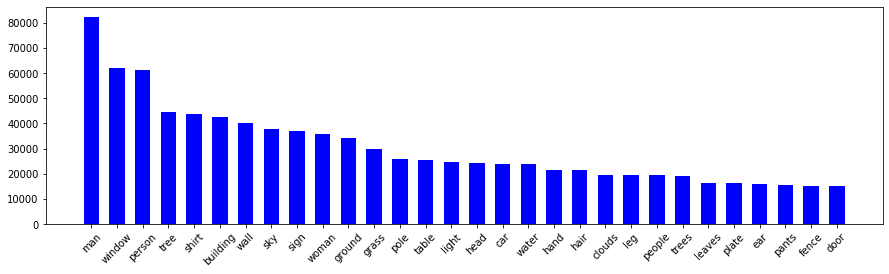

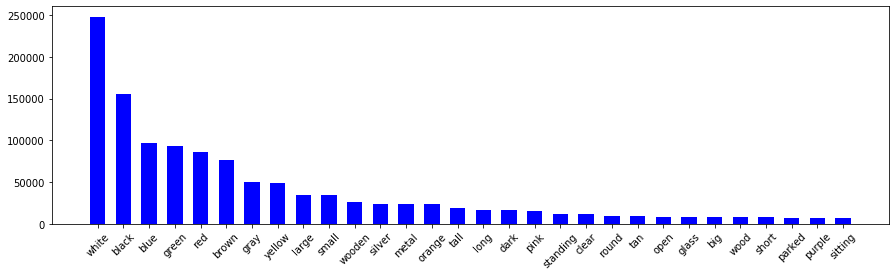

In [29]:
histogram(obj_to_cnt, 30)
histogram(att_to_cnt, 30)

In [30]:
# Least frequent object classes
obj_cnt = sorted(obj_to_cnt.items(), key=operator.itemgetter(1))[::-1]
print(obj_cnt[-10:-1])

[('shack', 68), ('sweatpants', 67), ('giraffe head', 67), ('masts', 67), ("pitcher's mound", 66), ('station wagon', 66), ('cub', 65), ('stereo', 65), ('washer', 63)]


In [31]:
# Least frequent attribute classes
att_cnt = sorted(att_to_cnt.items(), key=operator.itemgetter(1))[::-1]
print(att_cnt[-10:-1])

[('skate', 95), ('browned', 95), ('brake', 95), ('toilet paper', 91), ('windshield', 90), ('muscular', 89), ('unmade', 84), ('hilly', 79), ('powdered', 59)]


#### Let's see if we could use COCO API to load genome.

In [39]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [40]:
split = 'val'
json_file = f'../datasets/genome/annotations/filtered_instances_{split}.json'
genome_api = COCO(json_file)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [51]:
cat_ids = sorted(genome_api.getCatIds())
cats = genome_api.loadCats(cat_ids)

img_ids = sorted(list(genome_api.imgs.keys()))
imgs = genome_api.loadImgs(img_ids)

anns = [genome_api.imgToAnns[img_id] for img_id in img_ids]

#### Make sure (height, width) from image_meta is same as the real image.

In [3]:
for split in ['train', 'val', 'test']:
    print(f'Checking {split}')
    mismatch = 0
    instances = json.load(open(f'../datasets/genome/annotations/instances_{split}.json'))
    image_data = instances['images']
    for img in tqdm(image_data):
        im = plt.imread(osp.join('../datasets/vg', img['file_name']))
        h, w = im.shape[0], im.shape[1]
        if img['width'] != w or img['height'] != h:
            print('Discrepancy found for img_id[%s], expected_wh[%s,%s], real_wh[%s,%s]' % (img['id'], img['width'], img['height'], w, h))
            mismatch += 1
    print('%s mismatch found for [%s].' % (mismatch, split))

Checking train


100%|██████████| 97169/97169 [07:45<00:00, 208.92it/s]


0 mismatch found for [train].
Checking val


100%|██████████| 4945/4945 [00:24<00:00, 205.46it/s]


0 mismatch found for [val].
Checking test


100%|██████████| 4957/4957 [00:24<00:00, 204.80it/s]

0 mismatch found for [test].
